In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import Model
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter  
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import  MaxPooling1D, Embedding,LSTM,Dropout,add
from keras.callbacks import ModelCheckpoint
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

C:\Users\LENOVO\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [215]:
image = os.listdir("Flickr8k_Dataset/Flicker8k_Dataset")

In [216]:
model =VGG16()

In [217]:
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [218]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [219]:
features={}

for img in os.listdir("Flickr8k_Dataset/Flicker8k_Dataset"):
    paths = "Flickr8k_Dataset/Flicker8k_Dataset" + "/" + img
    image= load_img(paths, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)  
    feature= model.predict(image)
    img_id = img.split(".")[0]
    features[img_id] = feature

In [220]:
import pickle



with open('file_feature.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [223]:
with open('file_feature.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [224]:
train_images=open('Flickr8k_text/Flickr_8k.trainImages.txt','r').read().strip().split('\n')

In [225]:
tokens= open("Flickr8k_text/Flickr8k.token.txt","r").read().strip().split("\n")

In [226]:
captions={}
for i,lines in enumerate(tokens):
    lines=lines.split('\t')
    lines[0]= lines[0][:-2]
    if lines[0] in captions:
        captions[lines[0]].append(lines[1])
    else:
        captions[lines[0]] = [lines[1]]


In [227]:
description = []
for i,k in enumerate(captions):
    description.append(captions[k][0])
    captions[k] = captions[k][0]
   

In [228]:

from nltk.tokenize import word_tokenize

tokenized_feature = [word_tokenize(doc) for doc in description]


In [229]:
no_punct = []
for words in tokenized_feature:

    word=[w.lower() for w in words if w.isalpha()]
    no_punct.append(word)

In [230]:
clean_descriptions=[]
for words in no_punct:
    word=[w for w in words if len(w)>1]
    clean_descriptions.append(word)

In [231]:
for i in range(len(clean_descriptions)):
    clean_descriptions[i] = " ".join(w for w in clean_descriptions[i])
len(clean_descriptions)

8092

In [232]:
for i,k in enumerate(captions):
    
    captions[k] = 'start ' + clean_descriptions[i] + ' end'

In [233]:
for i in range(len(clean_descriptions)):
    clean_descriptions[i]= 'start ' + clean_descriptions[i] + ' end'

In [234]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from  keras import regularizers

In [235]:
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM=50

In [236]:
train_data = {}

for i in train_images:
    train_data[i]=captions[i]

In [237]:
train_data_vector={}
for i in train_images:
    train_data_vector[i]=b[i.split(".")[0]]

In [239]:
train_descriptions=[]
for i,k in train_data.items():
    train_descriptions.append(k)

In [240]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_descriptions)
sequences = tokenizer.texts_to_sequences(train_descriptions)


In [241]:
word2idx=tokenizer.word_index

In [242]:
vocab_size= len(word2idx) + 1
print(vocab_size)

3753


In [243]:
max_length=max(len(s) for s in train_descriptions)
print(max_length)

169


In [244]:
input1=[]
input2=[]
output=[]

for i,k in train_data_vector.items():
    seq=tokenizer.texts_to_sequences([train_data[i]])[0]
    for j in range(1,len(seq)):
        inp2,out = seq[:j],seq[j]
        inp2 = pad_sequences([inp2], maxlen=max_length)[0]
        out = keras.utils.to_categorical([out], num_classes=vocab_size)[0]
        input1.append(k)
        input2.append(inp2)
        output.append(out)
        
        
        
input1= np.asarray(input1)
input2=np.asarray(input2)
output=np.asarray(output)

In [245]:
input1.shape

(61145, 1, 4096)

In [246]:
input2.shape

(61145, 169)

In [247]:
output.shape

(61145, 3753)

In [248]:
input1=input1.reshape(-1,61145,4096)

In [249]:
input1.shape

(1, 61145, 4096)

In [379]:
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf-8") as f:
  
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [380]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      
      embedding_matrix[i] = embedding_vector

In [381]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_length,
  trainable=False
)

In [382]:
num_words

3753

In [383]:
inputs1 = Input(shape=(4096,))
x1 = Dropout(0.5)(inputs1)
x2 = Dense(256, activation='relu')(x1)

inputs2 = Input(shape=(max_length,))
y1 = embedding_layer(inputs2)
y2 = Dropout(0.5)(y1)
y3 = LSTM(256)(y2)
decoder1 = add([x2, y3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax', kernel_regularizer=regularizers.l2(.01))(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 169)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 169, 50)      187650      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [171]:
model.fit([input1[0], input2], output, epochs=50, batch_size=128)

Epoch 1/50
61145/61145 [==============================] - 724s 12ms/step - loss: 5.3552 - acc: 0.1748
Epoch 2/50
61145/61145 [==============================] - 702s 11ms/step - loss: 4.8183 - acc: 0.2281
Epoch 3/50
61145/61145 [==============================] - 698s 11ms/step - loss: 4.6496 - acc: 0.2464
Epoch 4/50
61145/61145 [==============================] - 698s 11ms/step - loss: 4.5388 - acc: 0.2579
Epoch 5/50
61145/61145 [==============================] - 707s 12ms/step - loss: 4.4441 - acc: 0.2698
Epoch 6/50
61145/61145 [==============================] - 704s 12ms/step - loss: 4.3705 - acc: 0.2790
Epoch 7/50
61145/61145 [==============================] - 702s 11ms/step - loss: 4.3067 - acc: 0.2855
Epoch 8/50
61145/61145 [==============================] - 703s 11ms/step - loss: 4.2569 - acc: 0.2899
Epoch 9/50
61145/61145 [==============================] - 699s 11ms/step - loss: 4.2260 - acc: 0.2933
Epoch 10/50
61145/61145 [==============================] - 696s 11ms/step - loss: 

In [36]:
from keras.models import load_model

In [ ]:
model.save("image_caption_net.h5")


In [250]:
model1=load_model("image_caption_net.h5")

In [251]:
test_images=open('Flickr8k_text/Flickr_8k.testImages.txt','r').read().strip().split('\n')

In [252]:
test_data = {}

for i in test_images:
    test_data[i]=captions[i]

In [253]:
test_data_vector={}
for i in test_images:
    test_data_vector[i]=b[i.split(".")[0]]
    

In [254]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [256]:
prediction={}
prob=[]
for i,k in test_data_vector.items():
    
    startseq = "start"
    
    for  j in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([startseq])[0]
       
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model1.predict([k,sequence], verbose=0)
        prob.append(yhat)

        yhat = np.argmax(yhat)

        word = word_for_id(yhat, tokenizer)

        if word is None:
            break

        startseq += ' ' + word

        if word == 'end':
            break
        if i in prediction:
            prediction[i].append(word)
        else:
            prediction[i] = [word]
    

In [258]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


In [259]:
idx2word={v:k for k,v in tokenizer.word_index.items()}
    

In [260]:
for i,k in prediction.items():
     prediction[i] = " ".join(w for w in prediction[i] )

In [261]:
len(prediction)

1000

In [268]:
beam_caption=[]
beam_captions={}
for i,k in test_data_vector.items():
    startseq= [['start',0.0]]
    while len(startseq[0][0]) < max_length:
        
        
        
        temp = []
        for s in startseq:
            
               
                sequence = tokenizer.texts_to_sequences([s[0]])[0]
                
                sequence = pad_sequences([sequence], maxlen=max_length)
                yhat = model1.predict([k,sequence], verbose=0)
                
                prob=np.argsort(yhat[0])[::-1][:3]
               
                top_words= [idx2word[i] for i in prob]
               

                for w in prob:
                    next_word=idx2word[w]
                    proba = s[1]
                    
                    proba+=yhat[0][w]
                    temp.append([s[0][:]+" "+ next_word,proba])
        
        startseq = temp
                
        startseq= sorted(startseq,reverse=False,key=lambda l:l[1])
        startseq= startseq[::-1][:3]
        
               
             
    startseq = startseq[0][0]
    
    
    for word in startseq.split(" ")[1:]:
        
        if word == 'end':
            beam_captions[i] = beam_caption
            
            beam_caption=[]
            break
                
        
            
        else:
            beam_caption.append(word)
          

In [269]:
for i,k in beam_captions.items():
     beam_captions[i] = " ".join(w for w in beam_captions[i] )

In [271]:
beam_captions

{'3385593926_d3e9c21170.jpg': 'brown dog is running in the snow',
 '2677656448_6b7e7702af.jpg': 'dog jumps into the air',
 '311146855_0b65fdb169.jpg': 'man in red hat and brown jacket holds an adult in his mouth',
 '1258913059_07c613f7ff.jpg': 'man in red jacket and red jacket is standing in front of red wall',
 '241347760_d44c8d3a01.jpg': 'football player holding the sooners to the sooners',
 '2654514044_a70a6e2c21.jpg': 'brown dog is running through the grass',
 '2339106348_2df90aa6a9.jpg': 'an asian woman is standing in the camera with her hand in the camera',
 '256085101_2c2617c5d0.jpg': 'brown and white dog bares its mouth on its mouth',
 '280706862_14c30d734a.jpg': 'black and white dog is running through the water',
 '3072172967_630e9c69d0.jpg': 'basketball player jumps the ball as the player',
 '3482062809_3b694322c4.jpg': 'man in yellow shirt is standing in the middle of the street',
 '1167669558_87a8a467d6.jpg': 'man with sunglasses looks at the camera',
 '2847615962_c330bded6

In [293]:
def feature_extract(model,path):
    image= load_img(path, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)  
    feature= model.predict(image)
    return feature

In [326]:
def greedy_search(model,tokenizer,image):
    pred = []
    startseq = "start"
    
    for  j in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([startseq])[0]
       
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([image,sequence], verbose=0)
        

        yhat = np.argmax(yhat)

        word = word_for_id(yhat, tokenizer)

        if word is None:
            break

        startseq += ' ' + word

        if word == 'end':
            break
        pred.append(word)
    pred=" ".join(w for w in pred)    
    return pred
    

In [327]:
def beam_search(model,tokenizer,image,beam_index):
    beam_caption_pred=[]
    startseq= [['start',0.0]]
    while len(startseq[0][0]) < max_length:
        temp = []
        for s in startseq:
            sequence = tokenizer.texts_to_sequences([s[0]])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([image,sequence], verbose=0)
            prob=np.argsort(yhat[0])[::-1][:beam_index]
            top_words= [idx2word[i] for i in prob]
            for w in prob:
                    next_word=idx2word[w]
                    proba = s[1]
                    
                    proba+=yhat[0][w]
                    temp.append([s[0][:]+" "+ next_word,proba])
        
        startseq = temp
                
        startseq= sorted(startseq,reverse=False,key=lambda l:l[1])
        startseq= startseq[::-1][:beam_index]
        
               
             
    startseq = startseq[0][0]
    
    
    for word in startseq.split(" ")[1:]:
        
        if word == 'end':
            break
                
        else:
            beam_caption_pred.append(word)
    beam_caption_pred = ' '.join(w for w in beam_caption_pred)
    return beam_caption_pred
    

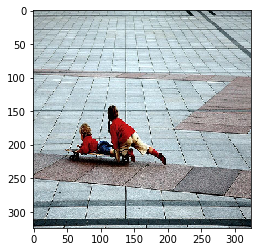

In [344]:
path= "Flickr8k_Dataset/Flicker8k_Dataset/2090545563_a4e66ec76b.jpg" 
img= load_img(path, target_size=(324,324))
plt.imshow(img)
plt.show()

In [345]:
img_feature= feature_extract(model,path)
greedy_pred=greedy_search(model1,tokenizer,img_feature)
beam_pred = beam_search(model1,tokenizer,img_feature,3)

In [361]:
print( "Greedy search prediction: %s" %greedy_pred)
print( "Beam search prediction:  %s" %beam_pred)

Greedy search prediction: boy in yellow shirt is skating skateboard on the wall
Beam search prediction:  boy in yellow shirt is grinding skateboard in the park


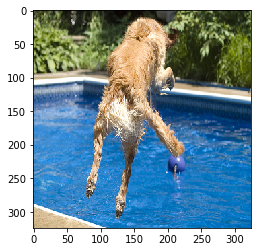

In [374]:
path= "Flickr8k_Dataset/Flicker8k_Dataset/1178705300_c224d9a4f1.jpg" 
img= load_img(path, target_size=(324,324))
plt.imshow(img)
plt.show()

In [377]:
img_feature= feature_extract(model,path)
greedy_pred=greedy_search(model1,tokenizer,img_feature)
beam_pred = beam_search(model1,tokenizer,img_feature,5)

In [378]:
print( "Greedy search prediction: %s" %greedy_pred)
print( "Beam search prediction:  %s" %beam_pred)

Greedy search prediction: brown dog is running into the water with another dog
Beam search prediction:  brown dog is running into the water
